2.1.1+cu118


# GraphSAGE model on heterogeneous user-article graph

In [1]:
import os

import torch
os.environ['TORCH'] = torch.__version__
from torch import Tensor
print(torch.__version__)

import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from torch import torch
from sklearn import preprocessing

from torch_geometric.data import Data

from torch_geometric.data import HeteroData
from torch_geometric.transforms import ToUndirected

from torch_geometric.loader import LinkNeighborLoader
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero, GAT
import torch.nn.functional as F


2.1.1+cu118


## Import data

In [2]:
postings_1 = pd.read_csv("../data/Postings_01052019_15052019.csv", sep = ';')
postings_2 = pd.read_csv("../data/Postings_16052019_31052019.csv", sep = ';')
votes_1 = pd.read_csv("../data/Votes_01052019_15052019.csv", sep = ';')
votes_2 = pd.read_csv("../data/Votes_16052019_31052019.csv", sep = ';')
postings = pd.concat([postings_1, postings_2])
votes = pd.concat([votes_1, votes_2])

post_article = postings.groupby(by = ['ID_CommunityIdentity', 'ID_Article']).agg({"ArticlePublishingDate": "min"})
post_article = post_article.reset_index()
votes_trunc = votes[['ID_CommunityIdentity', 'ID_Posting']]
postings_trunc = postings.groupby(by = ['ID_Posting', 'ID_Article']).agg({"ArticlePublishingDate": "min"}).reset_index().drop(columns = ['ArticlePublishingDate'])
vote_user_article = votes_trunc.merge(postings_trunc, left_on = ['ID_Posting'], right_on = ['ID_Posting'])
vote_article = vote_user_article.groupby(by = ['ID_CommunityIdentity', 'ID_Article']).agg({"ID_Posting": "count"}).reset_index().drop(columns = ['ID_Posting'])
user_article_interaction = pd.concat([post_article, vote_article]).drop(columns=['ArticlePublishingDate'])

user_article_interaction = user_article_interaction.groupby(by = ['ID_CommunityIdentity', 'ID_Article']).count().reset_index()

user_article_interaction["user_id"] = "u-" + user_article_interaction["ID_CommunityIdentity"].astype(str)
user_article_interaction["article_id"] = "a-" + user_article_interaction["ID_Article"].astype(str)

## Do node encoding

In [8]:
user_article_interaction_subsampled = user_article_interaction.sample(n=int(user_article_interaction.shape[0]), random_state=1)

# concatenate nodes and create node encodings
nodes = np.concatenate((np.unique(user_article_interaction_subsampled['user_id']), np.unique(user_article_interaction_subsampled['article_id'])))
nodes_user = np.unique(user_article_interaction_subsampled['user_id'])
nodes_article = np.unique(user_article_interaction_subsampled['article_id'])

label_encoder_nodes = preprocessing.LabelEncoder()
label_encoder_nodes.fit(nodes)
nodes_enc = label_encoder_nodes.transform(nodes)

user_article_interaction_subsampled['user_id_enc'] = label_encoder_nodes.transform(user_article_interaction_subsampled['user_id'])
user_article_interaction_subsampled['article_id_enc'] = label_encoder_nodes.transform(user_article_interaction_subsampled['article_id'])


In [9]:
user_id_key_val = dict(zip(list(range(0, len(np.unique(user_article_interaction_subsampled['user_id_enc'])))), 
                           list(np.unique(user_article_interaction_subsampled['user_id_enc']))))
article_id_val_key = dict(zip(list(range(0, len(np.unique(user_article_interaction_subsampled['article_id_enc'])))),
                               list(np.unique(user_article_interaction_subsampled['article_id_enc']))))
user_id_val_key = {v:k for k, v in user_id_key_val.items()}
article_id_key_val = {v:k for k, v in article_id_val_key.items()}

## Construct graph

In [10]:
# generate edge list
edge_list = []
for row in user_article_interaction_subsampled.itertuples():
    edge_list.append([user_id_val_key[row.user_id_enc], article_id_key_val[row.article_id_enc]])

# create tensor with nodes
x_s = torch.tensor([user_id_val_key[user_id] for user_id in np.unique(user_article_interaction_subsampled['user_id_enc'])], dtype=torch.long)
x_t = torch.tensor([article_id_key_val[article_id] for article_id in np.unique(user_article_interaction_subsampled['article_id_enc'])], dtype=torch.long)    

In [11]:
edge_index_s2t = torch.tensor(edge_list).t()
edge_index_t2s = edge_index_s2t.flip(0)

In [12]:
data = HeteroData()

data['user'].x = x_s
data['article'].x = x_t
data['user'].num_nodes = x_s.size(0)
data['article'].num_nodes = x_t.size(0)

data['user', 'article'].edge_index = edge_index_s2t
data['article', 'user'].edge_index = edge_index_t2s

data["user"].node_id = torch.arange(len(nodes_user))
data["article"].node_id = torch.arange(len(nodes_article))

data.num_nodes = x_s.size(0) + x_t.size(0)

# PyTorch tensor functionality:
data = data.pin_memory()
data = data.to('cuda:0', non_blocking=True)

In [13]:
# data = ToUndirected()(data)

In [14]:
data[("user", "to", "article")].edge_index

tensor([[14397,  8965, 11221,  ..., 13589, 14400, 33337],
        [ 2646,  1691,   881,  ...,  4239,   483,  2508]], device='cuda:0')

## Define the model

### Define node embedder

In [15]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

### Define classifier model

In [16]:
class Classifier(torch.nn.Module):

    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]] # select source node embeddings
        edge_feat_movie = x_movie[edge_label_index[1]] # select target node embeddings
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1) # calculate element-wise product

### Define model as a combination of node encoding and edge classification with dot-product

In [17]:
class Model(torch.nn.Module):
    
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["article"].num_nodes, hidden_channels)
        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()
        
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "article": self.movie_emb(data["article"].node_id),
        } 
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"], # user embeddings
            x_dict["article"], # item embeddings
            data["user", "to", "article"].edge_label_index, # supervised edge indices
        )
        # return torch.sigmoid(pred)
        return pred
    

In [19]:
data

HeteroData(
  num_nodes=38054,
  user={
    x=[33703],
    num_nodes=33703,
    node_id=[33703],
  },
  article={
    x=[4351],
    num_nodes=4351,
    node_id=[4351],
  },
  (user, to, article)={ edge_index=[2, 895196] },
  (article, to, user)={ edge_index=[2, 895196] }
)

## Model training

### Training parameters

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

NUM_TRAINING_EPOCHS = 20
LEARNING_RATE = 0.0001
SPLIT_VAL_RATIO = 0.1
SPLIT_TEST_RATIO = 0.1
SPLIT_DISJOINT_RATIO = 0.3
SPLIT_NEG_SAMPLING_RATIO = 2.0
TRAINING_NUM_NEIGHBORS = [50]
TRAINING_NEG_SAMPLING_RATIO = 2.0
TRAININING_BATCH_SIZE = 128

Device: 'cuda'


### Random link split. Train and test link neighbor loaders

In [21]:
import tqdm
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

transform = T.RandomLinkSplit(
    num_val=SPLIT_VAL_RATIO,
    num_test=SPLIT_TEST_RATIO,
    disjoint_train_ratio=SPLIT_DISJOINT_RATIO,
    neg_sampling_ratio=SPLIT_NEG_SAMPLING_RATIO,
    add_negative_train_samples=False,
    edge_types=("user", "to", "article"),
    rev_edge_types=("article", "to", "user"), 
)

train_data, val_data, test_data = transform(data)

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=TRAINING_NUM_NEIGHBORS,
    neg_sampling_ratio=TRAINING_NEG_SAMPLING_RATIO,
    edge_label_index=(("user", "to", "article"), train_data[("user", "to", "article")].edge_label_index,),
    edge_label=train_data[("user", "to", "article")].edge_label,
    batch_size=TRAININING_BATCH_SIZE,
    shuffle=True,
)

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=TRAINING_NUM_NEIGHBORS,
    edge_label_index=(("user", "to", "article"), test_data[("user", "to", "article")].edge_label_index),
    edge_label=test_data[("user", "to", "article")].edge_label,
    batch_size=128,
    shuffle=False,
)

/home/rgrebnev/anaconda3/envs/sna_link_prediction/lib/python3.9/site-packages/torch_geometric/sampler/neighbor_sampler.py:60: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


### Training procedure

In [22]:
def train(model, loader_train, loader_test, optimizer, device):

    train_ground_truth = []
    train_preds = []

    test_ground_truth = []
    test_preds = []

    train_total_loss = 0
    train_total_examples = 0

    test_total_loss = 0
    test_total_examples = 0
    
    for sampled_data in tqdm.tqdm(loader_train):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "to", "article"].edge_label
        train_ground_truth.append(ground_truth.cpu())
        train_preds.append(pred.cpu())

        # loss_train = F.binary_cross_entropy(pred, ground_truth)
        loss_train = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss_train.backward()
        optimizer.step()
        train_total_loss += float(loss_train.item()) * pred.numel()
        train_total_examples += pred.numel()
        
    for sampled_data in tqdm.tqdm(loader_test):
        with torch.no_grad():
            sampled_data.to(device)
            pred = model(sampled_data)
            ground_truth = sampled_data["user", "to", "article"].edge_label
            test_ground_truth.append(ground_truth.cpu())
            test_preds.append(pred.cpu())
            # loss_test = F.binary_cross_entropy(pred, ground_truth)
            loss_test = F.binary_cross_entropy_with_logits(pred, ground_truth)
            test_total_loss += float(loss_test.item()) * pred.numel()
            test_total_examples += pred.numel()

    metrics = {}
    metrics['TRAIN_ROC_AUC'] = roc_auc_score(torch.cat(train_ground_truth).cpu().detach().numpy(), torch.cat(train_preds).cpu().detach().numpy())
    metrics['TEST_ROC_AUC'] = roc_auc_score(torch.cat(test_ground_truth).cpu().detach().numpy(), torch.cat(test_preds).cpu().detach().numpy())
    metrics['TRAIN_LOSS'] = train_total_loss / train_total_examples
    metrics['TEST_LOSS'] = test_total_loss / test_total_examples
    return metrics

## Run training

In [23]:
metrics_train_roc_auc_list = []
metrics_test_roc_auc_list = []
metrics_train_loss_list = []
metrics_test_loss_list = []


model = Model(hidden_channels=64)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(0, NUM_TRAINING_EPOCHS + 1):
    metrics = train(model, train_loader, test_loader, optimizer, device)
    metrics_train_roc_auc_list.append(metrics['TRAIN_ROC_AUC'])
    metrics_test_roc_auc_list.append(metrics['TEST_ROC_AUC'])
    metrics_train_loss_list.append(metrics['TRAIN_LOSS'])
    metrics_test_loss_list.append(metrics['TEST_LOSS'])
    print(f"Epoch: {epoch:03d}, \n TRAIN_LOSS: {metrics['TRAIN_LOSS']:.4f}, \n TEST_LOSS: {metrics['TEST_LOSS']:.4f}, \n TRAIN_ROC_AUC: {metrics['TRAIN_ROC_AUC']:.4f}, \n TEST_ROC_AUC: {metrics['TEST_ROC_AUC']:.4f}")


/home/rgrebnev/anaconda3/envs/sna_link_prediction/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/rgrebnev/anaconda3/envs/sna_link_prediction/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/rgrebnev/anaconda3/envs/sna_link_prediction/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/rgrebnev/anaconda3/envs/sna_link_prediction/lib/python3.9/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
  0%|          | 0/1679 [00:00<?, ?it/s]

100%|██████████| 2099/2099 [00:28<00:00, 74.24it/s] 


Epoch: 000, 
 TRAIN_LOSS: 0.5071, 
 TEST_LOSS: 0.4454, 
 TRAIN_ROC_AUC: 0.7902, 
 TEST_ROC_AUC: 0.8549


100%|██████████| 2099/2099 [00:24<00:00, 86.68it/s] 


Epoch: 001, 
 TRAIN_LOSS: 0.3885, 
 TEST_LOSS: 0.3915, 
 TRAIN_ROC_AUC: 0.8915, 
 TEST_ROC_AUC: 0.8922


100%|██████████| 2099/2099 [00:27<00:00, 75.18it/s] 


Epoch: 002, 
 TRAIN_LOSS: 0.3597, 
 TEST_LOSS: 0.3710, 
 TRAIN_ROC_AUC: 0.9088, 
 TEST_ROC_AUC: 0.9037


100%|██████████| 2099/2099 [00:24<00:00, 87.38it/s] 


Epoch: 003, 
 TRAIN_LOSS: 0.3464, 
 TEST_LOSS: 0.3635, 
 TRAIN_ROC_AUC: 0.9159, 
 TEST_ROC_AUC: 0.9096


100%|██████████| 2099/2099 [00:27<00:00, 75.91it/s] 


Epoch: 004, 
 TRAIN_LOSS: 0.3386, 
 TEST_LOSS: 0.3561, 
 TRAIN_ROC_AUC: 0.9199, 
 TEST_ROC_AUC: 0.9131


100%|██████████| 2099/2099 [00:24<00:00, 85.78it/s] 


Epoch: 005, 
 TRAIN_LOSS: 0.3337, 
 TEST_LOSS: 0.3499, 
 TRAIN_ROC_AUC: 0.9223, 
 TEST_ROC_AUC: 0.9154


100%|██████████| 2099/2099 [00:30<00:00, 68.71it/s] 


Epoch: 006, 
 TRAIN_LOSS: 0.3299, 
 TEST_LOSS: 0.3505, 
 TRAIN_ROC_AUC: 0.9241, 
 TEST_ROC_AUC: 0.9166


100%|██████████| 2099/2099 [00:29<00:00, 70.05it/s] 


Epoch: 007, 
 TRAIN_LOSS: 0.3265, 
 TEST_LOSS: 0.3520, 
 TRAIN_ROC_AUC: 0.9256, 
 TEST_ROC_AUC: 0.9172


100%|██████████| 2099/2099 [00:25<00:00, 83.51it/s] 


Epoch: 008, 
 TRAIN_LOSS: 0.3245, 
 TEST_LOSS: 0.3465, 
 TRAIN_ROC_AUC: 0.9265, 
 TEST_ROC_AUC: 0.9184


100%|██████████| 2099/2099 [00:24<00:00, 86.66it/s] 


Epoch: 009, 
 TRAIN_LOSS: 0.3212, 
 TEST_LOSS: 0.3429, 
 TRAIN_ROC_AUC: 0.9281, 
 TEST_ROC_AUC: 0.9195


100%|██████████| 2099/2099 [00:24<00:00, 84.99it/s] 


Epoch: 010, 
 TRAIN_LOSS: 0.3188, 
 TEST_LOSS: 0.3424, 
 TRAIN_ROC_AUC: 0.9291, 
 TEST_ROC_AUC: 0.9199


100%|██████████| 2099/2099 [00:24<00:00, 87.09it/s] 


Epoch: 011, 
 TRAIN_LOSS: 0.3173, 
 TEST_LOSS: 0.3431, 
 TRAIN_ROC_AUC: 0.9298, 
 TEST_ROC_AUC: 0.9203


100%|██████████| 2099/2099 [00:25<00:00, 83.51it/s] 


Epoch: 012, 
 TRAIN_LOSS: 0.3150, 
 TEST_LOSS: 0.3480, 
 TRAIN_ROC_AUC: 0.9307, 
 TEST_ROC_AUC: 0.9207


100%|██████████| 2099/2099 [00:25<00:00, 82.58it/s] 


Epoch: 013, 
 TRAIN_LOSS: 0.3147, 
 TEST_LOSS: 0.3426, 
 TRAIN_ROC_AUC: 0.9308, 
 TEST_ROC_AUC: 0.9211


100%|██████████| 2099/2099 [00:26<00:00, 80.20it/s] 


Epoch: 014, 
 TRAIN_LOSS: 0.3118, 
 TEST_LOSS: 0.3407, 
 TRAIN_ROC_AUC: 0.9321, 
 TEST_ROC_AUC: 0.9214


100%|██████████| 2099/2099 [00:25<00:00, 80.80it/s] 


Epoch: 015, 
 TRAIN_LOSS: 0.3098, 
 TEST_LOSS: 0.3405, 
 TRAIN_ROC_AUC: 0.9330, 
 TEST_ROC_AUC: 0.9218


100%|██████████| 2099/2099 [00:25<00:00, 82.27it/s] 


Epoch: 016, 
 TRAIN_LOSS: 0.3088, 
 TEST_LOSS: 0.3382, 
 TRAIN_ROC_AUC: 0.9334, 
 TEST_ROC_AUC: 0.9217


100%|██████████| 2099/2099 [00:26<00:00, 80.63it/s] 


Epoch: 017, 
 TRAIN_LOSS: 0.3072, 
 TEST_LOSS: 0.3376, 
 TRAIN_ROC_AUC: 0.9340, 
 TEST_ROC_AUC: 0.9222


100%|██████████| 2099/2099 [00:26<00:00, 80.60it/s] 


Epoch: 018, 
 TRAIN_LOSS: 0.3055, 
 TEST_LOSS: 0.3361, 
 TRAIN_ROC_AUC: 0.9347, 
 TEST_ROC_AUC: 0.9225


100%|██████████| 2099/2099 [00:26<00:00, 80.17it/s] 


Epoch: 019, 
 TRAIN_LOSS: 0.3046, 
 TEST_LOSS: 0.3367, 
 TRAIN_ROC_AUC: 0.9351, 
 TEST_ROC_AUC: 0.9224


100%|██████████| 2099/2099 [00:25<00:00, 83.26it/s] 


Epoch: 020, 
 TRAIN_LOSS: 0.3034, 
 TEST_LOSS: 0.3396, 
 TRAIN_ROC_AUC: 0.9356, 
 TEST_ROC_AUC: 0.9226


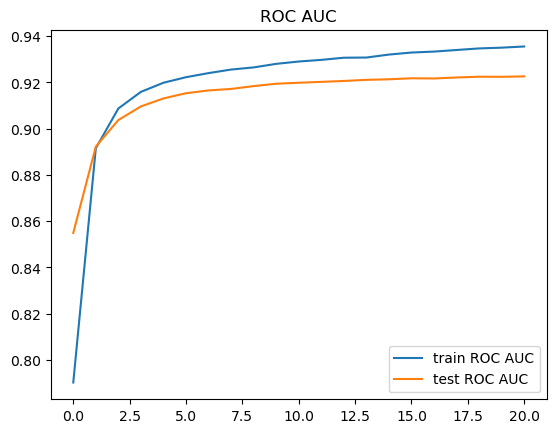

In [24]:
plt.title("ROC AUC")
plt.plot(metrics_train_roc_auc_list, label = 'train ROC AUC')
plt.plot(metrics_test_roc_auc_list, label = 'test ROC AUC')
plt.legend()

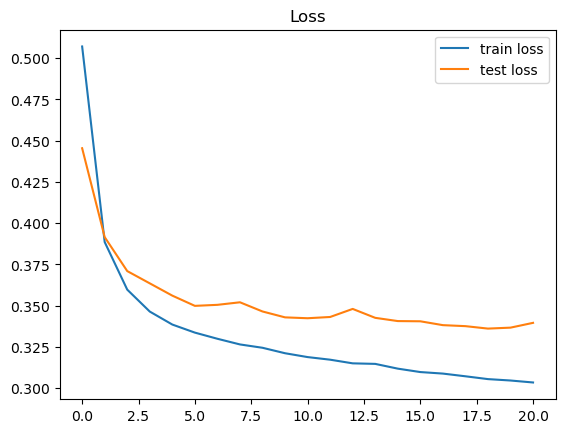

In [25]:
plt.title("Loss")
plt.plot(metrics_train_loss_list, label = 'train loss')
plt.plot(metrics_test_loss_list, label = 'test loss')
plt.legend()

## Validation

### Create validation link neighbor loader

In [26]:
# Define the validation seed edges:

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[50],
    edge_label_index=(("user", "to", "article"), val_data[("user", "to", "article")].edge_label_index),
    edge_label=val_data[("user", "to", "article")].edge_label,
    batch_size=128,
    shuffle=False,
)
sampled_data = next(iter(val_loader))

/home/rgrebnev/anaconda3/envs/sna_link_prediction/lib/python3.9/site-packages/torch_geometric/sampler/neighbor_sampler.py:60: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


### Run validation

In [27]:
from sklearn.metrics import roc_auc_score


preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "to", "article"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)

print()
print(f"Validation AUC: {auc:.4f}")

100%|██████████| 2099/2099 [00:23<00:00, 88.09it/s] 



Validation AUC: 0.9234
